In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import scipy.stats as stats

In [2]:
data=pd.read_csv("tripadvisor_hotel_reviews.csv")

In [3]:
data.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [4]:
print(data.shape)

(20491, 2)


In [5]:
data.isna().sum()

Review    0
Rating    0
dtype: int64

In [6]:
data.nunique().any()

True

# Descriptive statistics of the Rating variable 

In [7]:
data['Rating'].describe()

count    20491.000000
mean         3.952223
std          1.233030
min          1.000000
25%          3.000000
50%          4.000000
75%          5.000000
max          5.000000
Name: Rating, dtype: float64

<Axes: xlabel='Rating'>

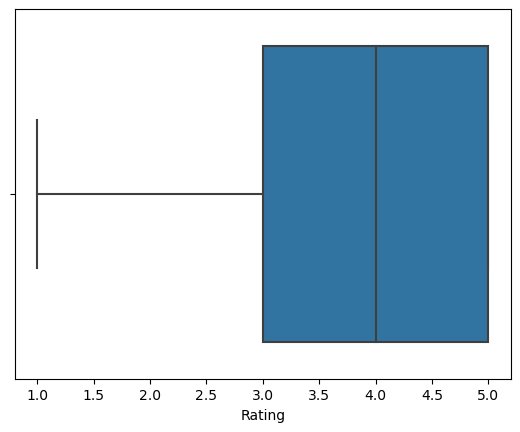

In [8]:
sns.boxplot(x=data["Rating"])

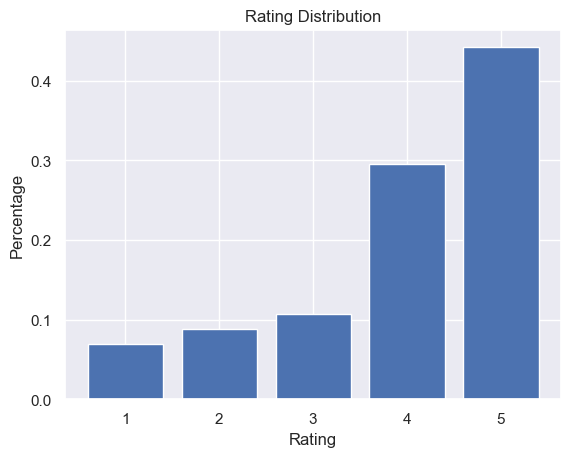

In [61]:
rating_counts = data['Rating'].value_counts(normalize=True).sort_index()
plt.bar(rating_counts.index, rating_counts.values)
plt.xlabel('Rating')
plt.ylabel('Percentage')
plt.title('Rating Distribution')
plt.show()

# Building the model 

importing the necessary library 

In [10]:
from collections import Counter
import re
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import string
import spacy
from tqdm.auto import tqdm
import time


Initiating the stop words and english words library 

In [11]:
nlp = spacy.load("en_core_web_lg")


In [12]:
stop_words = spacy.lang.en.stop_words.STOP_WORDS

Running a stop words function for text

In [13]:
def preprocess_text(text):
    doc = nlp(text)
    lemmas = [token.lemma_.lower() for token in doc if not token.is_stop]
    return " ".join(lemmas)

In [14]:
%%time

tqdm.pandas()

data['Review'] = data['Review'].progress_apply(preprocess_text)

  0%|          | 0/20491 [00:00<?, ?it/s]

CPU times: total: 7min 45s
Wall time: 8min 6s


In [15]:
def preprocess_signs(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+|#\w+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation)).lower()
    text = re.sub('\s+', ' ', text).strip()

    return text

applying the preprocess signs in the review columns 

In [16]:
data['Review'] = data['Review'].apply(preprocess_signs)

# analyzing the most used words in the review variable

In [17]:
import matplotlib.pyplot as plt
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
import nltk 

In [18]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
all_text = ' '.join(data['Review'].values)

splitting the text into words 

In [20]:
words = all_text.split()

Removing the stop words 

In [21]:
stop_words = set(stopwords.words('english'))
words = [word for word in words if not word in stop_words]

In [22]:
word_counts = Counter(words)

In [23]:
top_words = word_counts.most_common(50)

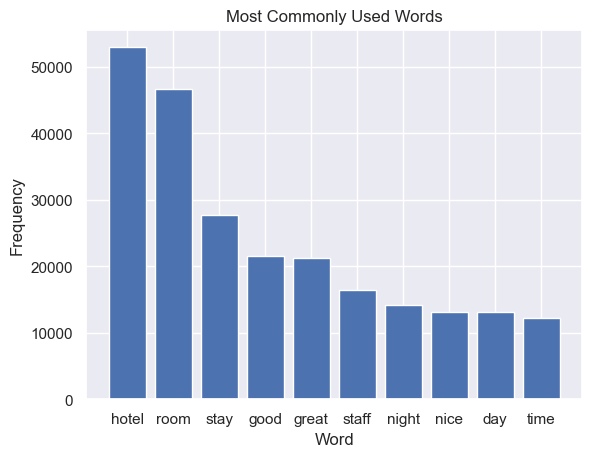

In [24]:
top_words = word_counts.most_common(10) 
x_values = [word[0] for word in top_words]
y_values = [word[1] for word in top_words]
plt.bar(x_values, y_values)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Most Commonly Used Words')
plt.show()

# Splitting the data into train and test sets 

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
X = data['Review']
y = data['Rating']

In [27]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)


In [28]:
print(Xtrain.shape)
print(Xtest.shape)
print(ytrain.shape)
print(ytest.shape)

(16392,)
(4099,)
(16392,)
(4099,)


In [29]:
Xtrain.head()

11710    outstanding cleanliness value location want st...
10444    cheap cheerful hey sure fuss pick hotel price ...
19183    sensational hotel stay hotel renew 2 10 novemb...
14261    nice spend 3 night easter nice little hotel fr...
1989     overall good experience enjoy stay hotel locat...
Name: Review, dtype: object

In [30]:
ytrain.head()

11710    5
10444    4
19183    5
14261    4
1989     4
Name: Rating, dtype: int64

# Converting the data to quantiative using vectorization 

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(Xtrain)
test_vectors = vectorizer.transform(Xtest)

In [32]:
train_vectors 

<16392x58526 sparse matrix of type '<class 'numpy.float64'>'
	with 1249412 stored elements in Compressed Sparse Row format>

In [33]:
test_vectors

<4099x58526 sparse matrix of type '<class 'numpy.float64'>'
	with 303457 stored elements in Compressed Sparse Row format>

# Creating and training  the models 

# support vector machines 

In [34]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [35]:
clf = OneVsRestClassifier(SVC(kernel='linear'))
clf.fit(train_vectors, ytrain)


OneVsRestClassifier(estimator=SVC(kernel='linear'))

In [36]:
clf_pred = clf.predict(test_vectors)


## Evaluating the model 

In [37]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [38]:
print(confusion_matrix(clf_pred,ytest))
print('accuracy_score:',accuracy_score(clf_pred, ytest))
print(classification_report(clf_pred, ytest))

[[ 217   76   23   11    3]
 [  40   83   55   28    1]
 [   8   63   88   49    9]
 [   9   76  198  548  225]
 [  18   35   68  616 1552]]
accuracy_score: 0.6069773115393998
              precision    recall  f1-score   support

           1       0.74      0.66      0.70       330
           2       0.25      0.40      0.31       207
           3       0.20      0.41      0.27       217
           4       0.44      0.52      0.47      1056
           5       0.87      0.68      0.76      2289

    accuracy                           0.61      4099
   macro avg       0.50      0.53      0.50      4099
weighted avg       0.68      0.61      0.63      4099



 # Naive Bayes Classifier 

In [39]:
from sklearn.naive_bayes import MultinomialNB

In [40]:
nb_clf = MultinomialNB()


In [41]:
nb_clf.fit(train_vectors, ytrain)

MultinomialNB()

In [42]:
nb_pred=nb_clf.predict(test_vectors)


# evaluating the model 

In [43]:
print(confusion_matrix(nb_pred,ytest))
print('accuracy_score:',accuracy_score(nb_pred, ytest))
print(classification_report(nb_pred, ytest))

[[   0    0    0    0    0]
 [   0    0    0    0    0]
 [   0    0    0    0    0]
 [  13   10    9    5    1]
 [ 279  323  423 1247 1789]]
accuracy_score: 0.43766772383508173
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.13      0.01        38
           5       1.00      0.44      0.61      4061

    accuracy                           0.44      4099
   macro avg       0.20      0.11      0.12      4099
weighted avg       0.99      0.44      0.61      4099



C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Random Forest 

In [44]:
from sklearn.ensemble import RandomForestClassifier

In [45]:
rndm_clf=RandomForestClassifier(n_estimators=100)

In [46]:
rndm_clf.fit(train_vectors,ytrain)

RandomForestClassifier()

In [47]:
rndm_pred=rndm_clf.predict(test_vectors)


# evaluating the model 

In [48]:
print(confusion_matrix(rndm_pred,ytest))
print('accuracy_score:',accuracy_score(rndm_pred, ytest))
print(classification_report(rndm_pred, ytest))

[[  87   25    3    0    0]
 [   9    7    3    0    0]
 [   1    6    5    0    0]
 [  51  108  200  278   95]
 [ 144  187  221  974 1695]]
accuracy_score: 0.5054891436935838
              precision    recall  f1-score   support

           1       0.30      0.76      0.43       115
           2       0.02      0.37      0.04        19
           3       0.01      0.42      0.02        12
           4       0.22      0.38      0.28       732
           5       0.95      0.53      0.68      3221

    accuracy                           0.51      4099
   macro avg       0.30      0.49      0.29      4099
weighted avg       0.79      0.51      0.59      4099



# Multinomial Logistic regression 

In [49]:
from sklearn.linear_model import LogisticRegression

In [50]:
log_clf=LogisticRegression(multi_class='multinomial', solver='lbfgs')

In [51]:
log_clf.fit(train_vectors,ytrain)

C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial')

In [52]:
log_pred=log_clf.predict(test_vectors)


# evaluating the model 

In [53]:
print(confusion_matrix(log_pred,ytest))
print('accuracy_score:',accuracy_score(log_pred, ytest))
print(classification_report(log_pred, ytest))

[[ 177   33   11    7    2]
 [  72  121   51   17    2]
 [  17   76  101   43    3]
 [  11   62  210  624  268]
 [  15   41   59  561 1515]]
accuracy_score: 0.6191754086362528
              precision    recall  f1-score   support

           1       0.61      0.77      0.68       230
           2       0.36      0.46      0.41       263
           3       0.23      0.42      0.30       240
           4       0.50      0.53      0.51      1175
           5       0.85      0.69      0.76      2191

    accuracy                           0.62      4099
   macro avg       0.51      0.57      0.53      4099
weighted avg       0.67      0.62      0.64      4099



# Plotting the accuracy and F1-scores of the different models 

In [54]:
models = ['Support Vector Machines','Naive Bayes Classifier','Random Forest','Multinomial Logistic Regression']
accuracies = [63.4,43.7,50.7,61.9]
f1_scores = [64.0,61.0,60.0,64.0]

- creating a bar plot for accuracy 

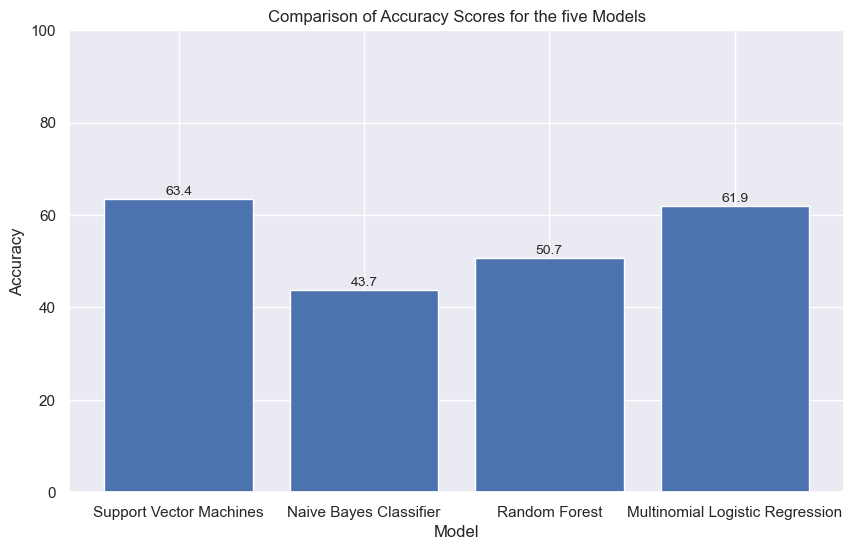

In [55]:
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(models, accuracies, color='b')
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_ylim([0, 100])
ax.set_title('Comparison of Accuracy Scores for the five Models')
for i, v in enumerate(accuracies):
    ax.text(i, v + 1, str(v), ha='center', fontsize=10)

- creating a line graph for the f1-scores 

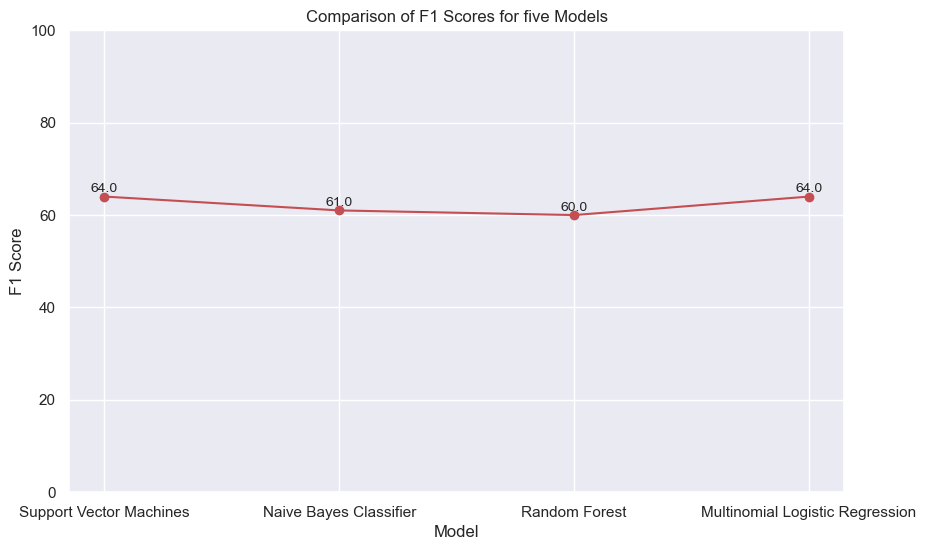

In [56]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(models, f1_scores, color='r', marker='o')
ax.set_xlabel('Model')
ax.set_ylabel('F1 Score')
ax.set_ylim([0, 100])

ax.set_title('Comparison of F1 Scores for five Models')
for i, v in enumerate(f1_scores):
    ax.text(i, v + 1, str(v), ha='center', fontsize=10)